<a href="https://colab.research.google.com/github/nadiasuweer4ya/TumorVision-Intelligent-Brain-Tumor-Analysis-and-Segmentation/blob/main/Brain_Tumor_Image_Clasiification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor Image Classification** ✨

**What is Brain Tumor?** 📚


A brain tumor, known as an intracranial tumor, is an abnormal mass of tissue in which cells grow and multiply uncontrollably, seemingly unchecked by the mechanisms that control normal cells.

**About Dataset** 🔔

This dataset is a combination of the following three datasets : figshare, SARTAJ, dataset Br35H.

This dataset contains **7023 images** of human brain MRI images which are classified into 4 classes:

**glioma - meningioma - no tumor and pituitary.**

no tumor class images were taken from the Br35H dataset.

# **Install Kaggle and Dataset**



Install the Kaggle library by running the following command in a code cell 👇

In [1]:
! pip install kaggle
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.7 MB/s eta 0:00:00


# **How to download Kaggle datasets in Google Colab** ✅

1. Go to the Kaggle website (https://www.kaggle.com/) and sign in to the account (or create a new one if you don't have an account).

2. Go to the "Account" section of Kaggle profile, scroll down to the "API" section, and click on the "Create New API Token" button. This will download a JSON file named "kaggle.json" containing Kaggle API credentials.

3. Upload the "kaggle.json" file to Google Colab environment. We can do this by clicking on the folder icon on the left sidebar of the Colab interface, selecting the "Files" tab, and clicking on the "Upload" button to upload the file.

4. Move the uploaded "kaggle.json" file to the appropriate directory by running the following command in a code cell. 👇

After running the command, the dataset will be downloaded to the current directory. We can unzip the dataset!

In [3]:
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json # Set the appropriate permissions
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

# **Import**

Import the essential library.

In [4]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils

from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Properties
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Set path of the train directory
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [7]:
# Create a function to customize autopct parameter of plt.pie()
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.2f}%  ({val})'
    return my_autopct

# **Data Preparing**

In [8]:
# Create Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [9]:
# Create Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [10]:
# Get labels inferred by the method itself
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
def plot_images(n_rows, n_cols, data_set):
    plt.figure(figsize=(n_cols*2.25, n_rows*2.25))
    for images, labels in train_ds.take(1):
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off')
            plt.title(class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

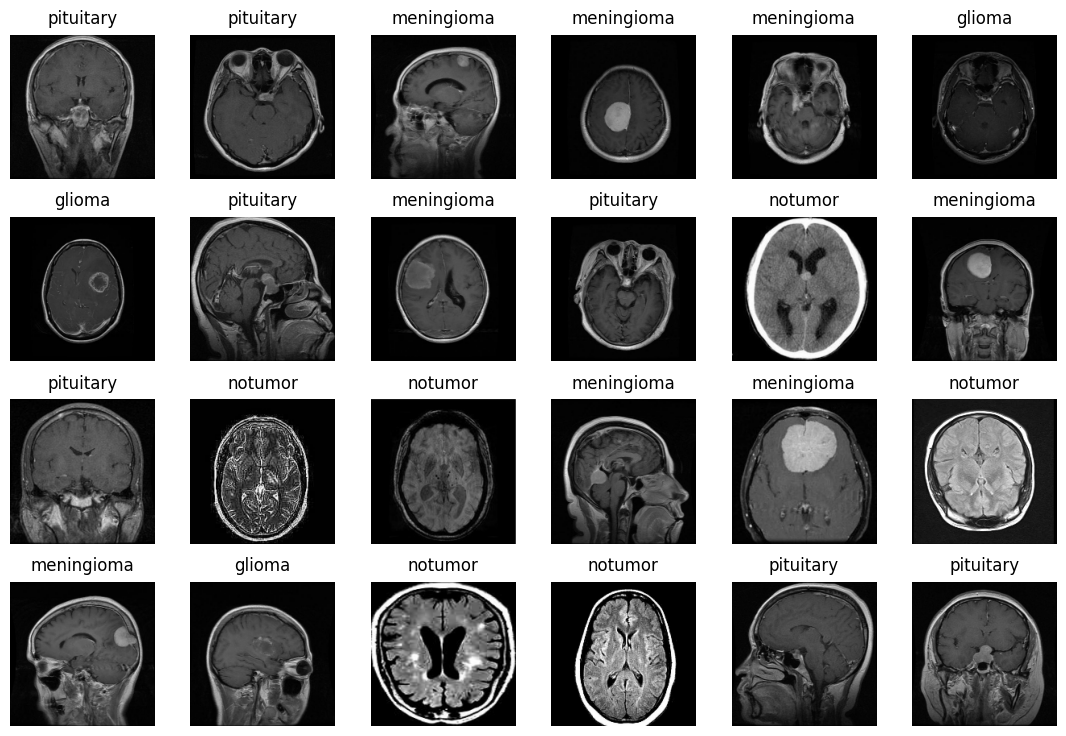

In [12]:
# View a few Images from Training dataset
plot_images(4, 6, train_ds)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Now we will scale pixels from range 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [16]:
def plot_images_augmented(dataset):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

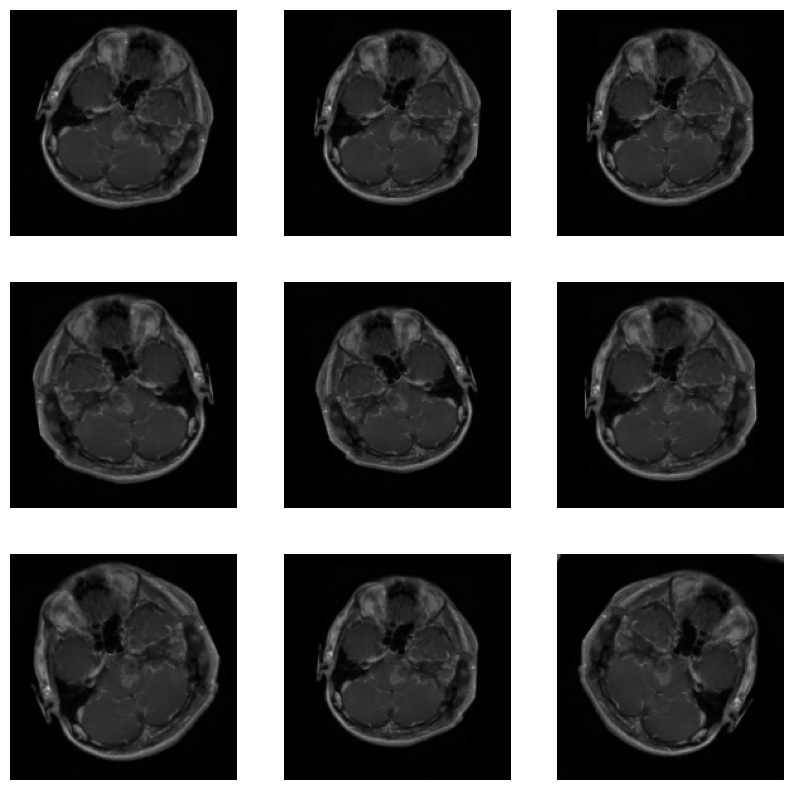

In [17]:
plot_images_augmented(train_ds)

# **Modeling**

In [18]:
# Create model
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [19]:
# Compile the above model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "modelCheckpoint/brainT_classification.h5"
)
# Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [21]:
# Fit model with our train data and cal-c validation
# score at each epoch
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
# Model is saved again! (at different path)
model.save("brainTumor_classification.h5")

Epoch 1/50
143/143 [==============================] - 20s 41ms/step - loss: 0.8994 - accuracy: 0.6278 - val_loss: 0.7314 - val_accuracy: 0.7408
Epoch 2/50
143/143 [==============================] - 4s 28ms/step - loss: 0.5871 - accuracy: 0.7691 - val_loss: 0.6225 - val_accuracy: 0.7855
Epoch 3/50
143/143 [==============================] - 4s 31ms/step - loss: 0.4805 - accuracy: 0.8131 - val_loss: 0.4855 - val_accuracy: 0.8152
Epoch 4/50
143/143 [==============================] - 4s 31ms/step - loss: 0.4393 - accuracy: 0.8368 - val_loss: 0.6060 - val_accuracy: 0.7811
Epoch 5/50
143/143 [==============================] - 4s 29ms/step - loss: 0.4137 - accuracy: 0.8460 - val_loss: 0.4182 - val_accuracy: 0.8292
Epoch 6/50
143/143 [==============================] - 4s 28ms/step - loss: 0.3563 - accuracy: 0.8646 - val_loss: 0.5226 - val_accuracy: 0.8135
Epoch 7/50
143/143 [==============================] - 4s 28ms/step - loss: 0.3315 - accuracy: 0.8751 - val_loss: 0.3584 - val_accuracy: 0.856

# **Evaluation**

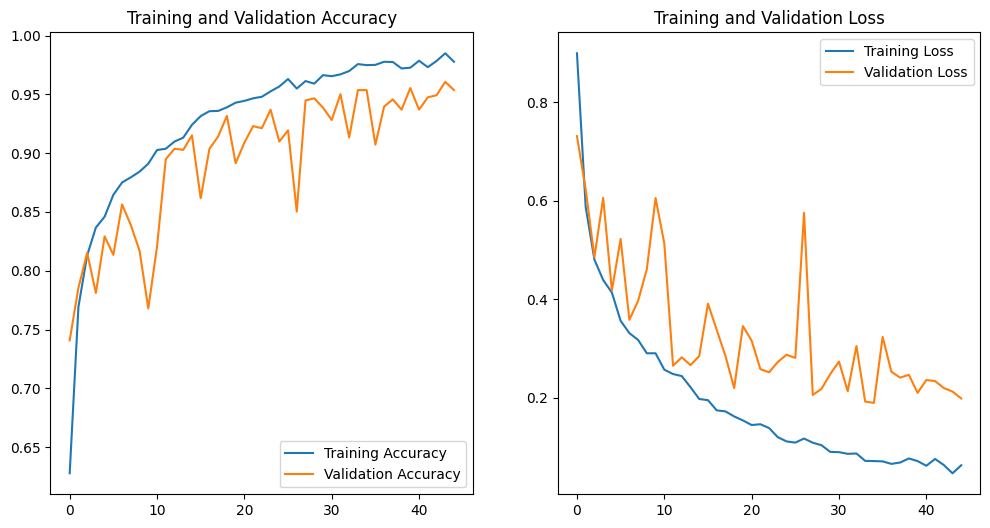

In [22]:
# Plot the training curves: train and validation accuracy & loss
epochs = len(history.epoch)
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Read test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1311 files belonging to 4 classes.


In [24]:
# Make predictions on test set
predictions = model.predict(test_ds)
scores = tf.nn.softmax(predictions[:])

41/41 [==============================] - 4s 72ms/step


In [25]:
for i in range(10):
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(scores[i])], 100 * np.max(scores[i]))
    )

This image most likely belongs to meningioma with a 94.44 percent confidence.
This image most likely belongs to glioma with a 99.57 percent confidence.
This image most likely belongs to notumor with a 99.99 percent confidence.
This image most likely belongs to pituitary with a 100.00 percent confidence.
This image most likely belongs to meningioma with a 99.93 percent confidence.
This image most likely belongs to pituitary with a 100.00 percent confidence.
This image most likely belongs to notumor with a 100.00 percent confidence.
This image most likely belongs to pituitary with a 99.90 percent confidence.
This image most likely belongs to pituitary with a 100.00 percent confidence.
This image most likely belongs to meningioma with a 99.79 percent confidence.


In [26]:
# Create two numpy arrays to store labels of test data and prediction
# of respective image
y_test_actual = np.array([])
y_pred_actual = np.array([])

# Iterate over every batch and enter data in created numpy arrays
for x, y in test_ds:
    # Convert label tensor to numpy and concatenate
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))
    # Process prediction score and concatenate result
    predictions = model.predict(x)
    scores = tf.nn.softmax(predictions[:])
    y_pred = np.argmax(scores, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

1/1 [==============================] - 0s 87ms/step


**Confusion Matrics and Classification Report**

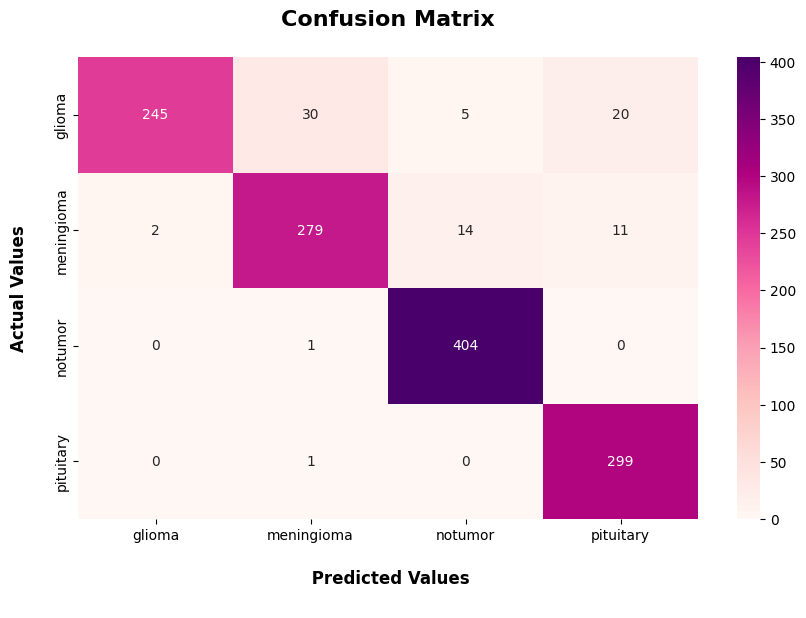

In [27]:
confusion = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(10,6))
fig = sns.heatmap(confusion, annot=True, fmt="d",cmap="RdPu")

fig.set_title('Confusion Matrix\n',
              fontdict={
                  "fontsize":16,
                  "fontweight": 'bold'
              })
fig.set_xlabel('\n Predicted Values\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.set_ylabel('Actual Values\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.xaxis.set_ticklabels(class_names)
fig.yaxis.set_ticklabels(class_names)
plt.show()

In [28]:
# Get classification report
print(classification_report(y_test_actual, y_pred_actual, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.99      0.82      0.90       300
  meningioma       0.90      0.91      0.90       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.91      1.00      0.95       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.93      1311



In [29]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.3 MB/s eta 0:00:00
   

In [31]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model("brainTumor_classification.h5")

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def classify_image(image):
    image = tf.image.resize(image, (img_height, img_width))
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    scores = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(scores)]
    confidence = 100 * np.max(scores)
    return f"This image most likely belongs to {predicted_class} with a {confidence:.2f} percent confidence."

# Create the Gradio interface
input_image = gr.inputs.Image(shape=(img_height, img_width))
output_text = gr.outputs.Textbox()

gr.Interface(
    fn=classify_image,
    inputs=input_image,
    outputs=output_text,
    live=True,
    title="Brain Tumor Classification",
    description="Upload an image to classify the brain tumor type."
).launch()


<ipython-input-31-37988811671c>:20: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  input_image = gr.inputs.Image(shape=(img_height, img_width))
<ipython-input-31-37988811671c>:20: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  input_image = gr.inputs.Image(shape=(img_height, img_width))
<ipython-input-31-37988811671c>:21: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  output_text = gr.outputs.Textbox()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>